In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# why object oriented - DRY
# if you have data and methods, functions on the data, you group them into classes - you separate issues
# data & operations on this data and encapsulate it

In [3]:
#1. modelling with sequential API - Sequential() - until now
#2. modelling with functional API - see notebook NLP_200807_variational_autoencoder
#3. modelling with sub-classing API (below)

In [4]:
# a class is a template for instances, it does NOT contain any data
# the instances contain the data
class AutoEncoder(tf.keras.Model): # inherit from keras. Now it knows the summary method
    
    def __init__(self, latent_dim):#, kernel_size, filters): # this is the constructor
        super().__init__() # it is calling the super-constructor, basically the parent. goes to  super = tf.keras.Model and on it
                            # calls the init function
        self.latent_dim = latent_dim # = 32 - if it is too small, it will become just construction and reconstruction - no good outputs
                                    # also the loss finction will increase
        #self.kernel_size = kernel_size
        #self.filters = filters
        self.encoder_reshape = tf.keras.layers.Reshape((784,))  # flattening 28*28. We could have also used the flatten
        self.encoder_fc1 = tf.keras.layers.Dense(256, activation="relu")
        #self.encoder_conv1 = tf.keras.layers.Conv1D(kernel_size=kernel_size, filters=filters, activation="relu")
        self.encoder_fc2 = tf.keras.layers.Dense(self.latent_dim, activation="relu") # Dense = fully connected
        
        self.decoder_fc1 = tf.keras.layers.Dense(256, activation="relu")
        #self.decoder_conv1 = tf.keras.layers.Conv1D(kernel_size=kernel_size, filters=filters, activation="relu")
        self.decoder_fc2 = tf.keras.layers.Dense(784, activation="sigmoid") # because every pixel is a binary classifier
                                                                            # we predict for each pixel a probability
                                                                            # we compare the pixes pair-wise
                                                                            # binary cross loss, because the softmax and resp. 
                                                                            # multi ... cross loss will sum up all to 1
        self.decoder_reshape = tf.keras.layers.Reshape((28, 28, 1)) # it comes out in the old shape
        
        self._build_graph()
        
    def _build_graph(self): # hidden - private methods - it is only coded by the class and not by the person coding
                            # it connects the layers
                            # you order by the order of execution - that is why build is before encode - because it calls the ones below

        input_shape = (28, 28, 1) # define shape
        self.build((None, ) + input_shape)  # define what is the input
                                            # None is a placeholder going to be the samples dimension; fit = 1; evaluate = batch_size
        inputs = tf.keras.Input(shape=input_shape)
        _ = self.call(inputs) # _ = placeholder, atomic variable # now we need to connect the layers
        
    
    def call(self, x): #= the entire Autoencoder
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def encode(self, x):
        x = self.encoder_reshape(x) # output 784
        x = self.encoder_fc1(x) # output 256
        #x = self.encoder_conv1(x) # output 256
        z = self.encoder_fc2(x) # output 32
        return z 
 
    def decode(self, z): # z = latent vector or a batch of latent vectors
        z = self.decoder_fc1(z) # output 256
        #z = self.decoder_conv1(z) # output 256        
        z = self.decoder_fc2(z) # output 784
        x_prime = self.decoder_reshape(z) # output (28, 28, 1)
        return x_prime

    

autoencoder = AutoEncoder(32)#, 256, 4)
#print(autoencoder.latent_dim)
#print(autoencoder.encoder_reshape)
#print(autoencoder.decoder_reshape)
autoencoder.summary()

autoencoder.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy"

)

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 419,120
Trainable params: 419,120
Non-trainable params: 0
________________________________________________

In [5]:
(mnist_train_original, mnist_validate_original, mnist_test_original), info = tfds.load(
    name="mnist",
    split=["train[:80%]", "train[80%:]", "test"],
    with_info=True,
    as_supervised=True
)

def encode(image):
    image_encoded = tf.image.convert_image_dtype(image, dtype=tf.float32) # from tensorflow
    return image_encoded, image_encoded # twice, because we would use the original image as a label. I need input & output

mnist_train = mnist_train_original.map(lambda image, _: encode(image)).cache() # normalising, shuffling, making sure it can work with batches
                                                            # image = normalise, 
                                                            #label - we are not going to do anything with it in this case
mnist_validate = mnist_validate_original.map(lambda image, _: encode(image)).cache()
mnist_test = mnist_test_original.map(lambda image, _: encode(image)).cache()

In [6]:
def render_predictions():
    
    mnist_examples = list(mnist_test.take(8).as_numpy_iterator())
    index = 1
    plt.figure(figsize=(8, 2))
    for image, _ in mnist_examples: 
        prediction = autoencoder.predict(np.array([image]))[0]
        # First row is the data, the next reconstruction
        plt.subplot(2, 8, index) # index the number I am currently at
        plt.axis("off")
        plt.imshow(image[:, :, 0], cmap="inferno")
        plt.subplot(2, 8, index + 8) # going down
        plt.axis("off")
        plt.imshow(prediction[:, :, 0], cmap="inferno")
        index += 1
    plt.show()
    plt.close()

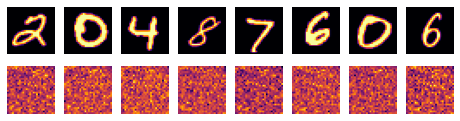

In [7]:
render_predictions()

In [8]:
history = autoencoder.fit(
    mnist_train.shuffle(10000).batch(256),
    epochs=50,
    validation_data=mnist_validate.batch(256) # NO SHUFFLE!!!!

)

Epoch 1/50
188/188 [==============================] - 4s 19ms/step - loss: 0.2042 - val_loss: 0.1580
Epoch 2/50
188/188 [==============================] - 1s 7ms/step - loss: 0.1425 - val_loss: 0.1317
Epoch 3/50
188/188 [==============================] - 1s 7ms/step - loss: 0.1251 - val_loss: 0.1176
Epoch 4/50
188/188 [==============================] - 1s 7ms/step - loss: 0.1164 - val_loss: 0.1135
Epoch 5/50
188/188 [==============================] - 1s 8ms/step - loss: 0.1107 - val_loss: 0.1054
Epoch 6/50
188/188 [==============================] - 1s 8ms/step - loss: 0.1063 - val_loss: 0.1086
Epoch 7/50
188/188 [==============================] - 1s 8ms/step - loss: 0.1032 - val_loss: 0.1002
Epoch 8/50
188/188 [==============================] - 1s 8ms/step - loss: 0.1007 - val_loss: 0.1010
Epoch 9/50
188/188 [==============================] - 1s 7ms/step - loss: 0.0988 - val_loss: 0.0986
Epoch 10/50
188/188 [==============================] - 1s 8ms/step - loss: 0.0970 - val_loss: 0.096

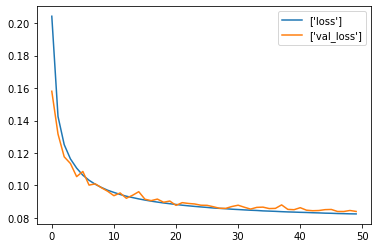

In [9]:
def plot_history(history):
    plt.plot(history.history["loss"], label=['loss'])
    plt.plot(history.history["val_loss"], label=['val_loss'])
    plt.legend()
    plt.show()
    plt.close()

plot_history(history)

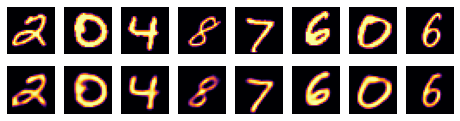

In [10]:
render_predictions()

# 2. Part

In [11]:
def render_dataset():
    mnist_examples = list(mnist_train.take(8).as_numpy_iterator())
    index = 1
    plt.figure(figsize=(8, 2))
    for image_in, image_out in mnist_examples:
        plt.subplot(2, 8, index)
        plt.axis("off")
        plt.imshow(image_in[:,:,0], cmap="inferno")
        plt.subplot(2, 8, index + 8)
        plt.axis("off")
        plt.imshow(image_out[:,:,0], cmap="inferno")
        index += 1
    plt.show()
    plt.close()

In [12]:
autoencoder = AutoEncoder(32)

autoencoder.summary()

autoencoder.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy"

)

Model: "auto_encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
Total params: 419,120
Trainable params: 419,120
Non-trainable params: 0
______________________________________________

In [30]:
(mnist_train_original, mnist_validate_original, mnist_test_original), info = tfds.load(
    name="mnist",
    split=["train[:80%]", "train[80%:]", "test"],
    with_info=True,
    as_supervised=True
)

def encode(image):
    image_encoded = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    noise = tf.random.normal(
        shape = image.shape,
        mean=0.9, stddev=0.8,
        dtype=tf.dtypes.float32
    )
    image_noised = tf.clip_by_value(image_encoded + noise, 0.0, 1.0)
    
    return image_noised, image_encoded   # if I switch them to image_encoded, image_noised, I get a noiser 

mnist_train = mnist_train_original.map(lambda image, _: encode(image)).cache()
mnist_validate = mnist_validate_original.map(lambda image, _: encode(image)).cache()
mnist_test = mnist_test_original.map(lambda image, _: encode(image)).cache()

In [31]:
#history = autoencoder.fit(
#    mnist_train.shuffle(10000).batch(256),
#    epochs=50,
#    validation_data=mnist_validate.batch(256) 

#)

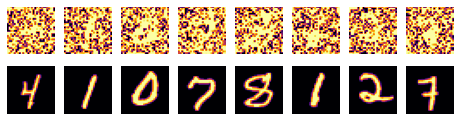

In [32]:
render_dataset()

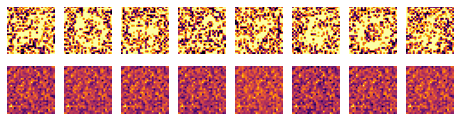

In [33]:
render_predictions()

In [17]:
# underfitting - loss is still not 0
# overfitting - train loss is less than the validation